### PHATE Analysis on Tabular Dataset

Here we run a PHATE analysis on the tabular dataset with our cells. 


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phate
import seaborn as sns
import dbcv
from sklearn import preprocessing

from scipy.stats import zscore

pd.set_option('display.max_rows', None)


#### Data Loading and Processing

Reading in the data and the optimal features selected in the Stallaert et al., 2022.:

In [10]:
CELLS = "/media/omar/1354B7D111621BC0/projects/unc/wayne_rpe/data/full_df.csv"
FEATURES = "/media/omar/1354B7D111621BC0/projects/unc/wayne_rpe/data/feature_df_v6_noIntgStdOver.csv"
CELL_PREDICTIONS = "/media/omar/1354B7D111621BC0/projects/unc/wayne_rpe/data/labels_original.csv"

CELLS_DF = pd.read_csv(CELLS)
CELL_PREDICTIONS_DF = pd.read_csv(CELL_PREDICTIONS)
FEATURES_DF = pd.read_csv(FEATURES)

CELLS_DF.rename(columns={CELLS_DF.columns[0]: 'cell_id'}, inplace=True)
CELLS_DF.sort_index(inplace=True)
CELLS_DF.drop('pred_phase', axis=1, inplace=True)

/tmp/ipykernel_93506/2642006137.py:5: DtypeWarning: Columns (3109,3117,3123,3132,3139,3141,3154,3155,3156,3157,3158,3169) have mixed types. Specify dtype option on import or set low_memory=False.
  CELLS_DF = pd.read_csv(CELLS)


Here we read in the phase predictions of the cells and merge onto the dataframe to help evaluate clustering performance:

In [11]:
# Remove unlabeled cellsencoded_phase
CELL_PREDICTIONS_DF.dropna(axis=0, subset='pred_phase', inplace=True)
CELLS_DF = pd.merge(CELL_PREDICTIONS_DF, CELLS_DF, how='left', on='cell_id')
CELLS_DF.set_index('cell_id', inplace=True)
len(CELLS_DF)

5920

Now we encode the cycle phases into digits:

In [12]:
encoder = preprocessing.LabelEncoder()

CELLS_DF['pred_phase_encoded'] = encoder.fit_transform(CELLS_DF['pred_phase'])

# We print out the encodings 
print(CELLS_DF.groupby(['pred_phase_encoded','pred_phase']).size().reset_index().rename(columns={0:'count'}))

   pred_phase_encoded pred_phase  count
0                   0         G1   3440
1                   1         G2    752
2                   2          M     45
3                   3          S   1683


#### PHATE

Here are the parameter values that have been optimized via hyperparameters sweep:

In [13]:
config = {
    'rank_by': 'rank',
    'n_features': 200,
    'z_score': True,
    'gamma': 1,
    't': 20,
    'knn': 200
}


In [16]:
# Start by sorting features by the column from config
FEATURES_DF.sort_values(config['rank_by'])

# Subset features
FEATURES_SUBSET = FEATURES_DF.iloc[:config['n_features'], :] 

# Cells with necessary features
CELLS_FEATS = CELLS_DF[list(FEATURES_SUBSET['Row.names'])]

if config['z_score']:
    CELLS_FEATS = CELLS_FEATS.apply(zscore)
    
    
phate_operator = phate.PHATE(knn=config['knn'],
                                t=config['t'],
                                gamma=config['gamma'],
                                n_components=3,
                                random_state=416)

CELLS_PHATE = phate_operator.fit_transform(CELLS_FEATS)
LABELS = CELLS_DF['pred_phase_encoded'].to_numpy()

score = dbcv.dbcv(CELLS_PHATE, LABELS, n_processes=4)

print(f'DBCV Score: {score}')

Calculating PHATE...
  Running PHATE on 5920 observations and 200 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.51 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.22 seconds.
    Calculating affinities...
    Calculated affinities in 0.35 seconds.
  Calculated graph and diffusion operator in 5.18 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.70 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.35 seconds.
  Calculated landmark operator in 6.44 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.62 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.79 seconds.
Calculated PHATE in 14.04 seconds.
DBCV Score: 0.0


In [28]:
LABELS

array([0, 3, 0, ..., 0, 3, 0])

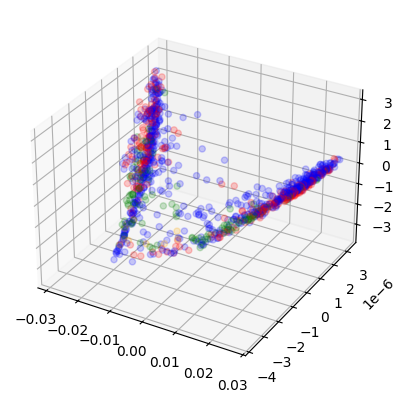

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Pick random points from the array so as not to overpopulate the plot
n = 1000
indices = np.random.choice(CELLS_PHATE.shape[0], n, replace=False)

X = CELLS_PHATE[indices, 0]
Y = CELLS_PHATE[indices, 1]
Z = CELLS_PHATE[indices, 2]

cmap = np.array(['blue', 'green', 'orange', 'red'])
COLORS = cmap[LABELS[indices]]

ax.scatter(X, Y, Z, c=COLORS, alpha=0.2)